<a href="https://colab.research.google.com/github/itc202/praktik/blob/main/%D0%9F%D0%B5%D1%80%D0%B5%D0%BD%D0%BE%D1%81_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D1%8F_VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Перенос обучения в задаче определения типа сцены из набора данных [Intel Image Classification](https://www.kaggle.com/puneet6060/intel-image-classification)

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (Файл -> Создать копию на Диске). Свою копию вы сможете изменять и запускать.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions





## Загружаем данные

In [ ]:
!wget https://www.dropbox.com/s/pnq8ej5c9ti1se7/intel_scene.zip?dl=1 -O intel_scene.zip

--2023-10-18 04:58:36--  https://www.dropbox.com/s/pnq8ej5c9ti1se7/intel_scene.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/pnq8ej5c9ti1se7/intel_scene.zip [following]
--2023-10-18 04:58:37--  https://www.dropbox.com/s/dl/pnq8ej5c9ti1se7/intel_scene.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc2bf6dc9b0882666596b3065b9.dl.dropboxusercontent.com/cd/0/get/CF1u3o-d14JBggTzhgB0ASxUWyKGwdP33hM4N7EGfhe6apBB-Pp9sBgC8diBKoqBOxt_RwLy3v_YNg2DUoR2-5kVOhpGsphCae1q1Tfl-eUPs-qDUWKc1FNTf-qHL7UGn3IxQ90GCFCGHohDN0djTBgd/file?dl=1# [following]
--2023-10-18 04:58:37--  https://ucc2bf6dc9b0882666596b3065b9.dl.dropboxusercontent.com/cd/0/get/CF1u3o-d14JBggTzhgB0ASxUWyKGwdP33hM4N7EGfhe6apBB-Pp9sBgC8diBKoqBOxt_RwLy3v_YNg2DUoR2-5kVO

In [ ]:
!unzip intel_scene.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train

In [ ]:
!ls seg_train/seg_train

buildings  forest  glacier  mountain  sea  street


**Набор данных для обучения**

In [ ]:
train_dataset = image_dataset_from_directory('seg_train/seg_train',
                                             subset='training',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=128,
                                             image_size=(128, 128))

Found 14034 files belonging to 6 classes.
Using 12631 files for training.


In [ ]:
validation_dataset = image_dataset_from_directory('seg_train/seg_train',
                                             subset='validation',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=128,
                                             image_size=(128, 128))

Found 14034 files belonging to 6 classes.
Using 1403 files for validation.


In [ ]:
class_names = train_dataset.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

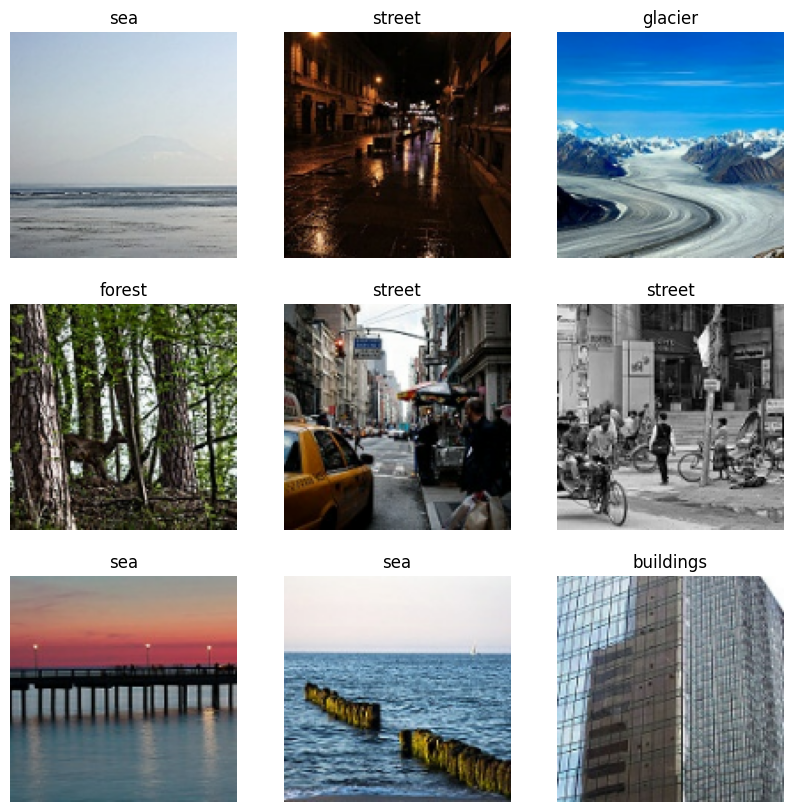

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Набор данных для тестирования**

In [ ]:
test_dataset = image_dataset_from_directory('seg_test/seg_test',
                                             shuffle=True,
                                             label_mode='int',
                                             batch_size=128,
                                             image_size=(128, 128))

Found 3000 files belonging to 6 classes.


In [ ]:
test_dataset.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Создаем нейронную сеть

In [ ]:
vgg16_net = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128, 128, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_net.trainable = False

In [ ]:
model = Sequential()
model.add(Normalization())
# Добавляем модель VGG16 в сеть как слой
model.add(vgg16_net)
model.add(Flatten()) # слой преобразует данные 2D из сверточной сети в плоский формат
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

**Компилируем модель**

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

## Обучаем нейронную сеть

In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=10)

Epoch 1/10
99/99 [==============================] - 41s 277ms/step - loss: 2.2026 - accuracy: 0.7801 - val_loss: 0.3997 - val_accuracy: 0.8596
Epoch 2/10
99/99 [==============================] - 19s 185ms/step - loss: 0.4320 - accuracy: 0.8560 - val_loss: 0.3372 - val_accuracy: 0.8852
Epoch 3/10
99/99 [==============================] - 19s 183ms/step - loss: 0.3679 - accuracy: 0.8797 - val_loss: 0.3431 - val_accuracy: 0.9052
Epoch 4/10
99/99 [==============================] - 19s 184ms/step - loss: 0.3269 - accuracy: 0.8940 - val_loss: 0.3469 - val_accuracy: 0.8902
Epoch 5/10
99/99 [==============================] - 18s 179ms/step - loss: 0.2676 - accuracy: 0.9101 - val_loss: 0.3335 - val_accuracy: 0.9102
Epoch 6/10
99/99 [==============================] - 19s 185ms/step - loss: 0.2414 - accuracy: 0.9169 - val_loss: 0.3397 - val_accuracy: 0.9059
Epoch 7/10
99/99 [==============================] - 18s 181ms/step - loss: 0.2379 - accuracy: 0.9186 - val_loss: 0.3425 - val_accuracy: 0.9073

## Оцениваем качество обучения сети

In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)

24/24 [==============================] - 7s 281ms/step - loss: 0.4037 - accuracy: 0.8963


In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 89.6333


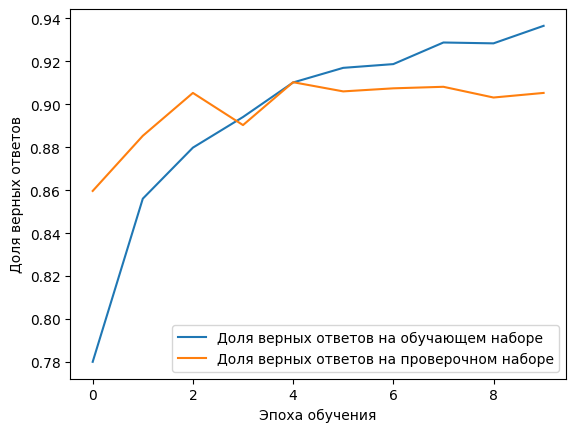

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

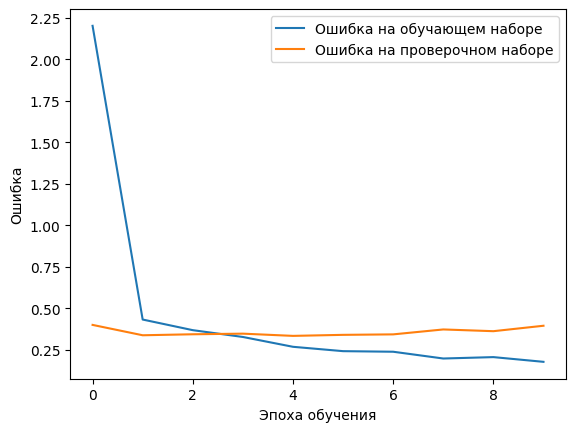

In [ ]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

## Тонкая настройка нейронной сети

In [ ]:
vgg16_net.trainable = True
trainable = False
for layer in vgg16_net.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=1e-5),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=3)

Epoch 1/3
99/99 [==============================] - 25s 242ms/step - loss: 0.0663 - accuracy: 0.9752 - val_loss: 0.4928 - val_accuracy: 0.9166
Epoch 2/3
99/99 [==============================] - 25s 244ms/step - loss: 0.0654 - accuracy: 0.9776 - val_loss: 0.5215 - val_accuracy: 0.9173
Epoch 3/3
99/99 [==============================] - 25s 247ms/step - loss: 0.0595 - accuracy: 0.9762 - val_loss: 0.5284 - val_accuracy: 0.9180


## Оцениваем качетсво обучения сети

In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)

24/24 [==============================] - 5s 194ms/step - loss: 0.5192 - accuracy: 0.9073


In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 90.2667


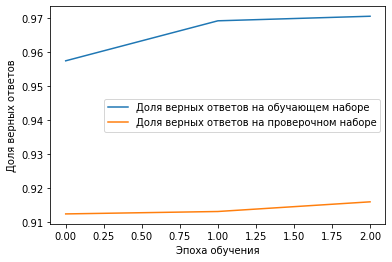

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Сохраняем обученную нейронную сеть

In [ ]:
model.save("intel_image_model.h5")

In [ ]:
!ls

 10675.jpg	       'mntns (1).jpg'	 sea.jpg    seg_train
 intel_image_model.h5   mntns.jpg	 seg_pred   street.jpg
 intel_scene.zip        sample_data	 seg_test


In [ ]:
files.upload()

NameError: ignored

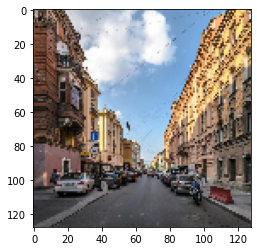

In [ ]:
filename = 'street.jpg'
img = image.load_img(filename, target_size=(128, 128))
plt.imshow(img)
plt.show()

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
preds = model.predict(x)
print(preds)


[[4.4215926e-06 2.8002844e-35 1.4505330e-25 0.0000000e+00 1.4410777e-28
  9.9999559e-01]]
